In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pokemon = pd.read_csv("Pokemon.csv")

In [3]:
pokemon.shape

(800, 13)

In [4]:
pp.ProfileReport(pokemon)

Number of variables,13
Number of observations,800
Total Missing (%),3.7%
Total size in memory,75.9 KiB
Average record size in memory,97.1 B
Numeric,8
Categorical,2
Boolean,1
Date,0
Text (Unique),1
Rejected,1


In [5]:
y = pokemon.Legendary
X = pokemon[['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation']]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
print(X_train.shape)
print(X_test.shape)

(560, 8)
(240, 8)


In [8]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn import metrics

clf = XGBClassifier(max_depth=10,
                    learning_rate=0.1,
                    n_estimators=300,
                    silent=True,
                    objective="binary:logistic",
                    nthread=-1,
                    missing=np.nan,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    base_score=0.5,
                    seed=42)

In [9]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
              subsample=0.9)

In [10]:
prob = clf.predict_proba(X_test)[:,1]
pred = clf.predict(X_test)

In [11]:
print("AUC:"+str(metrics.roc_auc_score(y_test, prob)))
print("Acurácia:"+str(metrics.accuracy_score(y_test, pred)))

AUC:0.9813333333333334
Acurácia:0.9666666666666667


In [12]:
from pygam import LinearGAM, s

In [13]:
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
gam.gridsearch(X_test.values, prob)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False)

In [14]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     36.5025
Link Function:                     IdentityLink Log Likelihood:                                 -6821.8409
Number of Samples:                          240 AIC:                                            13718.6868
                                                AICc:                                           13733.0189
                                                GCV:                                                0.0182
                                                Scale:                                              0.0133
                                                Pseudo R-Squared:                                   0.7921
Feature Function                  Lam

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


<Figure size 800x550 with 0 Axes>

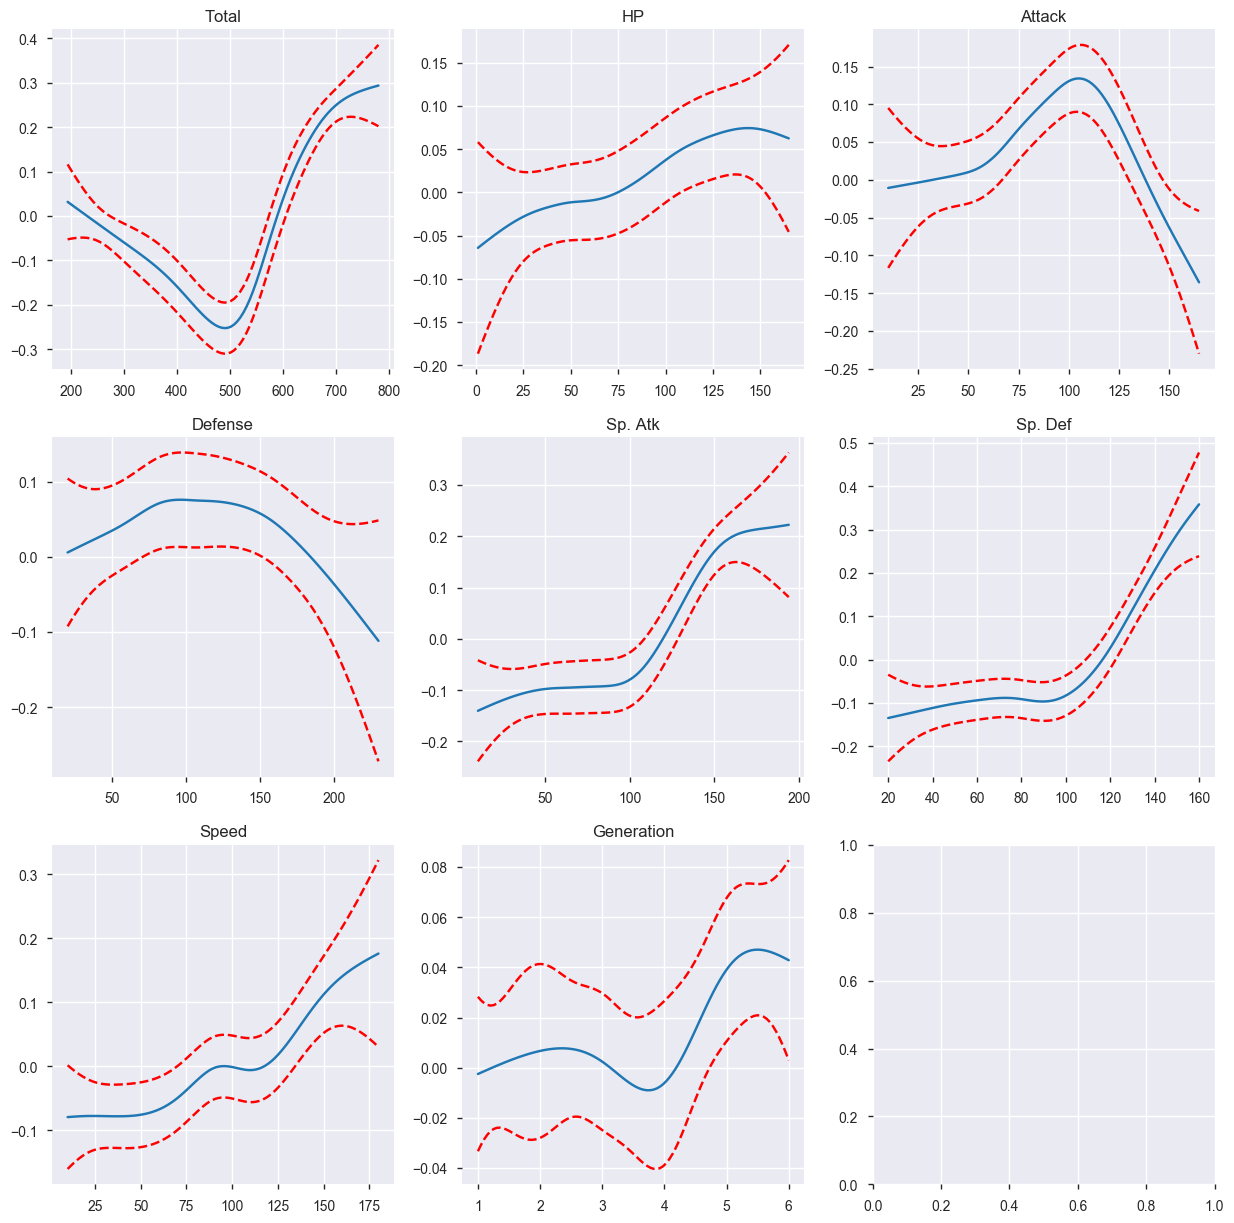

In [15]:
## plotting
plt.figure();
fig, axs = plt.subplots(3,3,figsize=(15,15));

titles = X_test.columns
cont = 0
for i in range(3):
    for j in range(3):
        XX = gam.generate_X_grid(term=cont)
        axs[i,j].plot(XX[:, cont], gam.partial_dependence(term=cont, X=XX))
        axs[i,j].plot(XX[:, cont], gam.partial_dependence(term=cont, X=XX, width=.95)[1], c='r', ls='--')
        axs[i,j].set_title(titles[cont]);
        if cont==7:
            break
        cont=cont+1

In [16]:
import shap

/usr/local/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [17]:
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [18]:
explainer.expected_value

-3.2774298

In [19]:
a = y_test.reset_index()
a = a[a.Legendary==True]

In [20]:
a

,index,Legendary
38,796,True
46,423,True
65,422,True
70,545,True
72,795,True
80,428,True
96,705,True
110,425,True
149,537,True
156,798,True


In [21]:
shap.initjs()
index=1
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index,:])

In [22]:
shap.initjs()
index=38
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index,:])

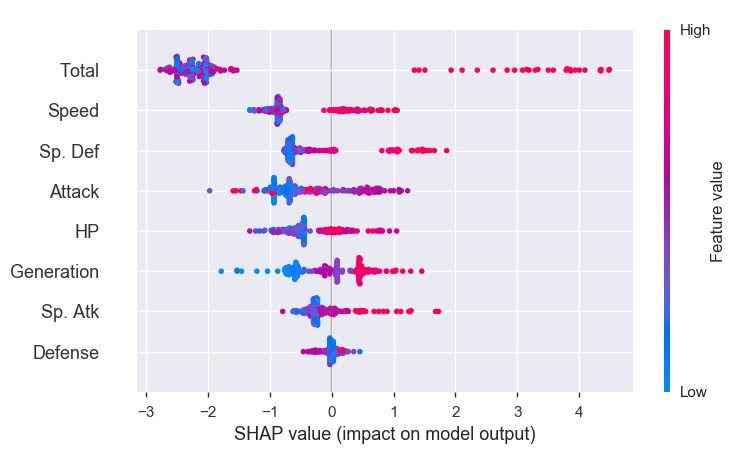

In [23]:
shap.summary_plot(shap_values, X_test)

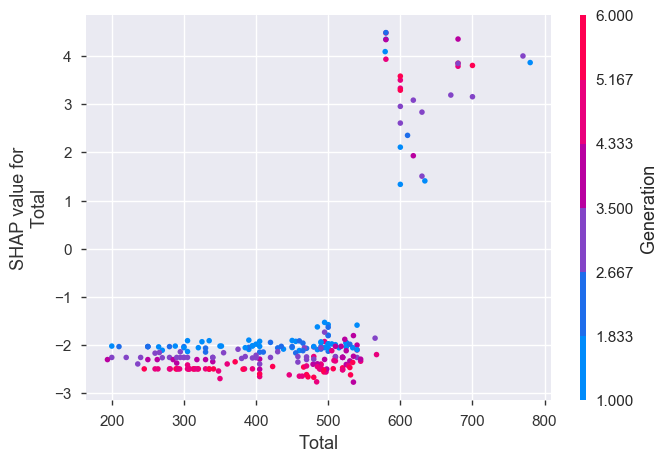

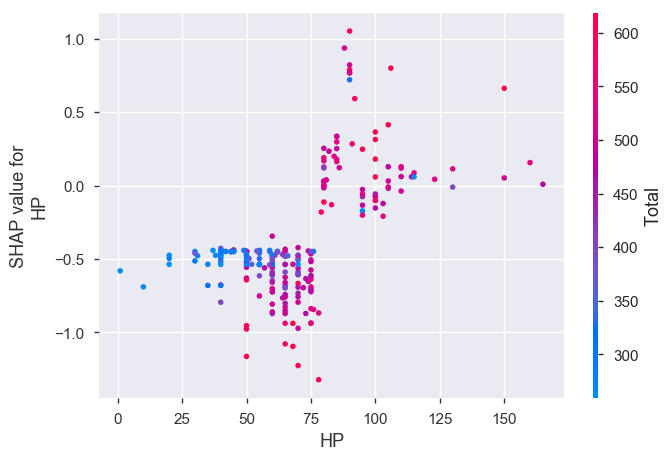

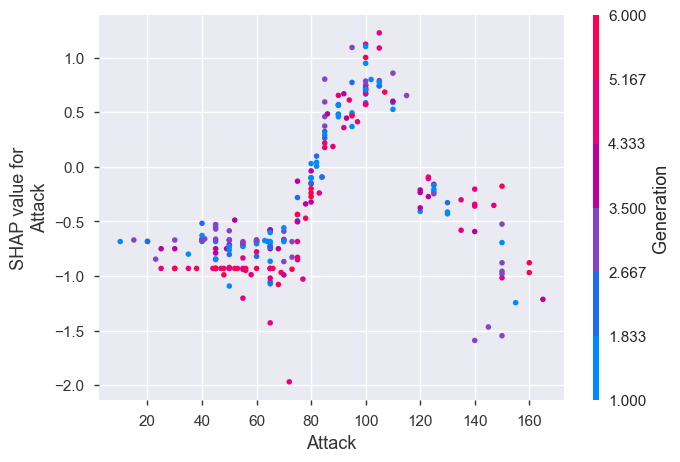

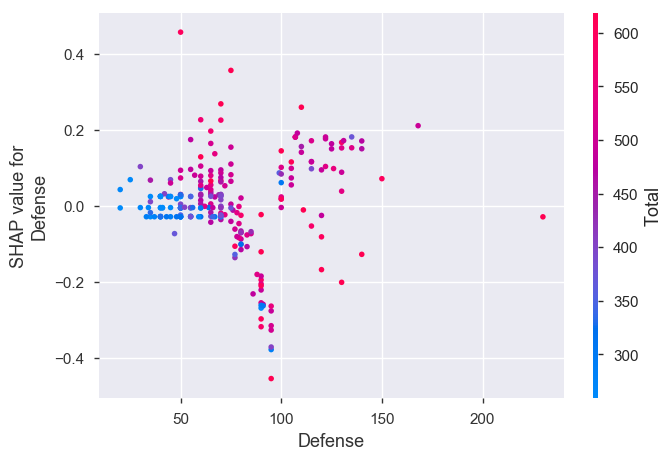

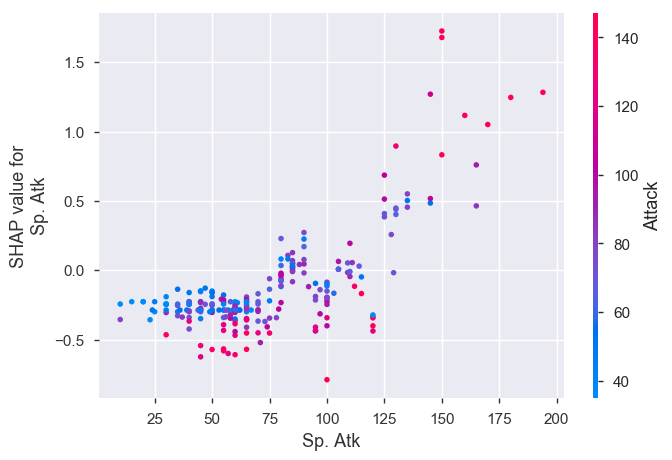

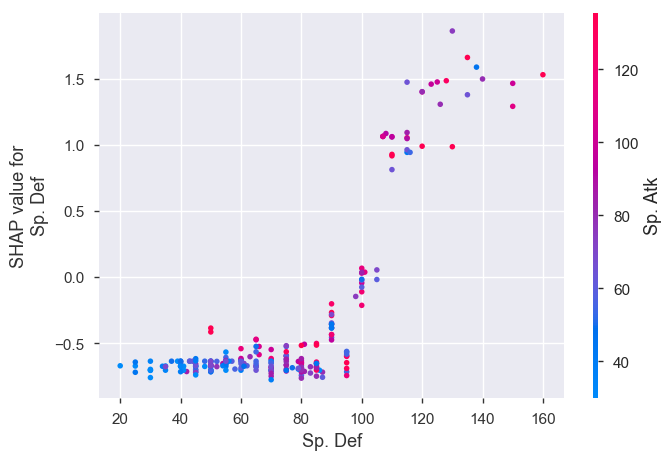

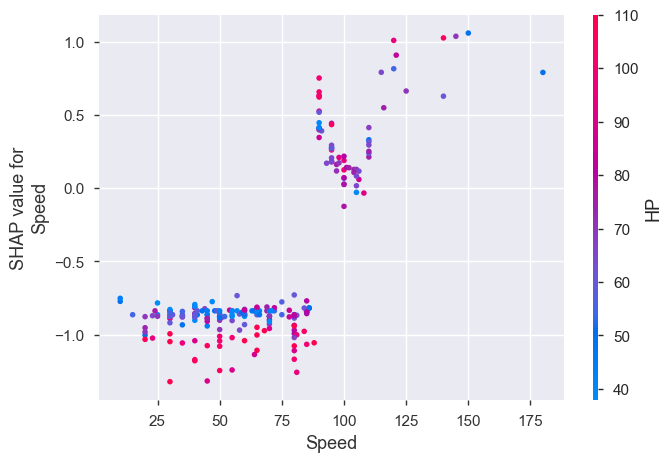

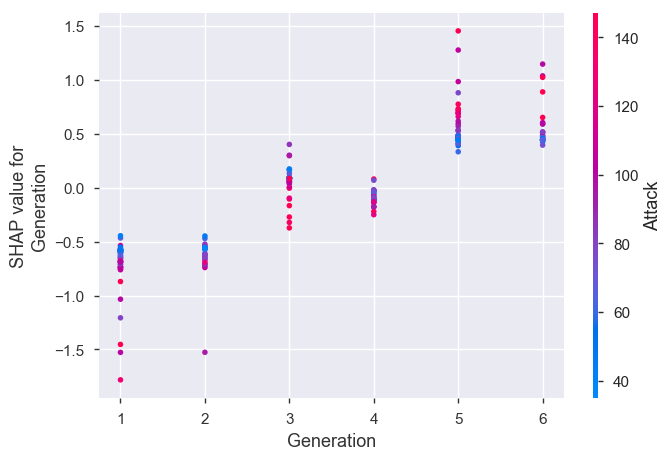

In [24]:
for i in X_test.columns:
    shap.dependence_plot(i, shap_values, X_test)

In [25]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X_test)

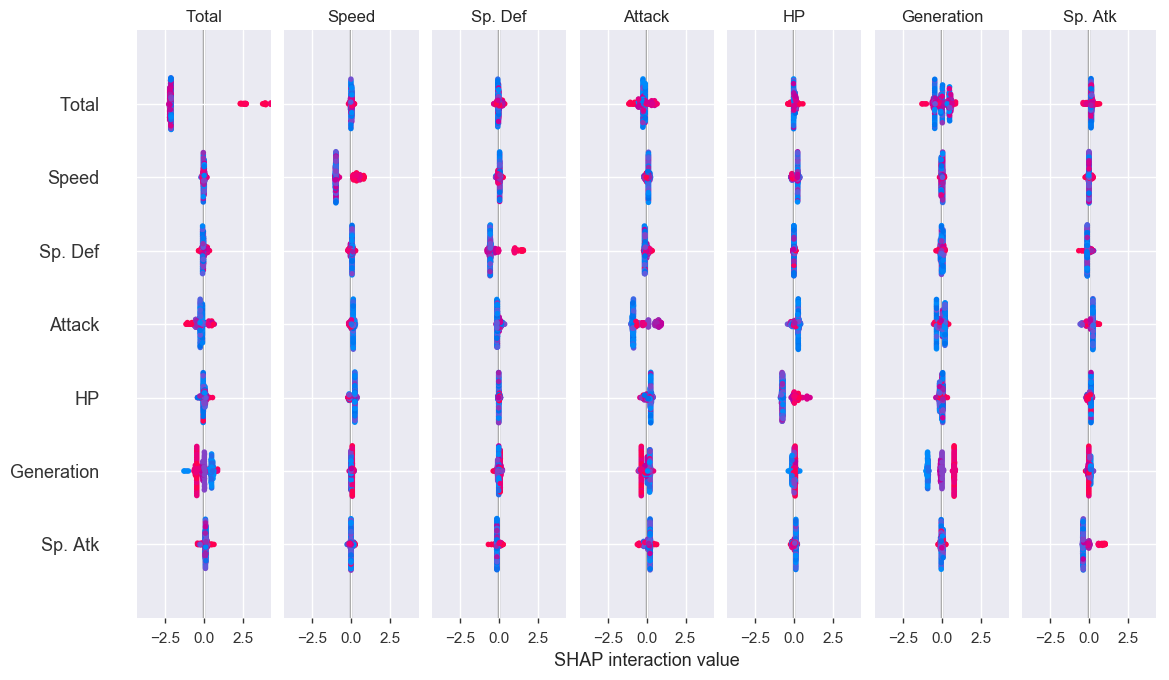

In [26]:
shap.summary_plot(shap_interaction_values, X_test)

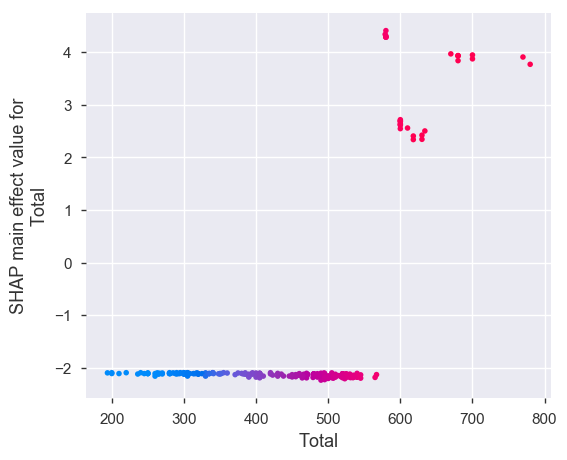

In [27]:
shap.dependence_plot(
    ("Total", "Total"),
    shap_interaction_values, X_test,
    display_features=X_test
)

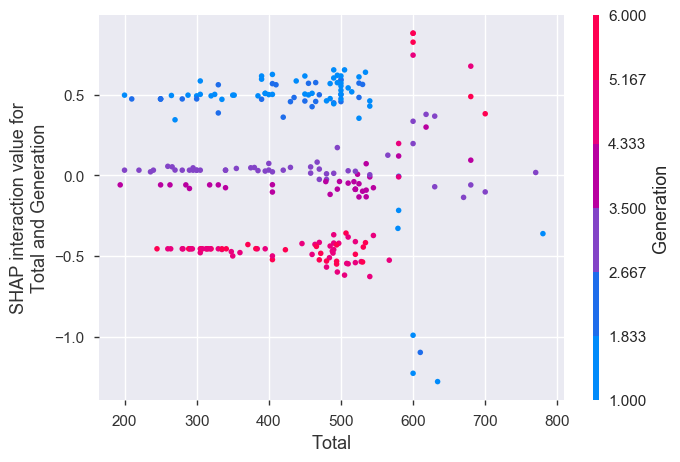

In [28]:
shap.dependence_plot(
    ("Total", "Generation"),
    shap_interaction_values, X_test,
    display_features=X_test
)